#### GoogLeNet

This notebook is an implement of [___Going deeper with convolutions___](https://arxiv.org/pdf/1409.4842.pdf) by Szedegy et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and thus takes less space to store on clusters and less time for training. 

We first need to install and import all the dependent libraries in the session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2021-12-22 19:44:44.461432: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-22 19:45:30.760224: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-22 19:45:30.886331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-22 19:45:30.886362: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-22 19:45:30.922065: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-22 19:45:30.922119: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set and test set. 

In [2]:
def get_data():
    train, test = tfds.as_numpy(tfds.load("cifar10", split = ["train", "test"]
                                          , shuffle_files = True, as_supervised = True, batch_size = -1))
    
    return train[0], test[0], train[1], test[1]

train_x, test_x, train_y, test_y = get_data()
train_x = train_x / 255.0
test_x = test_x / 255.0

2021-12-22 19:45:31.962649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-22 19:45:31.965065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1869] Adding visible gpu devices: 0
2021-12-22 19:45:31.966438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-22 19:45:31.968861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1869] Adding visible gpu devices: 0
2021-12-22 19:45:31.968882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1256] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-22 19:45:31.968890: I tensorflow/core/com

This is function that constructs a GoogLeNet model. In ```inception``` function we constructs an inception block while in ```createGoogLeNet``` function we build a fine-tuned GoogLeNet model. The structure of the model is almost same with the original paper, but the kernel size and strides are adjusted to fit the smaller pictures of Cifar 10. The most important change is that we only keep four inception layers because the images are very small and deep network would only cause overfitting instead of increasing performance. We define ```weight_decay``` as the hyperparameters of the model for kernel regularization.

In [3]:
def inception(input, f1, f3r, f3, f5r, f5, pp, weight_decay, output = False, output_name = None):
    x1 = Conv2D(kernel_size = 1, filters = f1, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(input)
    
    x2 = Conv2D(kernel_size = 1, filters = f3r, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(input)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(kernel_size = 3, filters = f3, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(x2)
    
    x3 = Conv2D(kernel_size = 1, filters = f5r, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(input)
    x3 = BatchNormalization()(x3)
    x3 = Conv2D(kernel_size = 5, filters = f5, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(x3)
     
    x4 = MaxPooling2D(pool_size = 3, padding = "same", strides = 1)(input)
    x4 = Conv2D(kernel_size = 1, filters = pp, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(x4)
    
    x5 = None
    
    if output == True:
        x5 = GlobalAveragePooling2D()(x)
        x5 = Conv2D(kernel_size = 1, padding = "same", filters = 128, activation = "relu", kernel_regularizer = l2(weight_decay))(x5)
        x5 = BatchNormalization()(x5)
        x5 = Flatten()(x5)
        x5 = Dense(1024, activation = "relu", kernel_regularizer = l2(weight_decay))(x5)
        x5 = Dropout(rate = .7)(x5)
        x5 = Dense(10, activation = "softmax", name = output_name)(x5)
    
    x = Concatenate()([x1, x2, x3, x4])
    x = BatchNormalization()(x)
    x = Dropout(.3)(x)
    return x, x5

def createGoogLeNet(weight_decay):
    input = Input(shape = (32, 32, 3), name = "image")
    x, _ = inception(input, 64, 96, 128, 16, 32, 32, weight_decay)
    x, _ = inception(x, 128, 128, 192, 32, 96, 64, weight_decay)
    x, _ = inception(x, 192, 96, 208, 16, 48, 64, weight_decay)
    x, _ = inception(x, 160, 112, 224, 24, 64, 64, weight_decay)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(rate = .7)(x)
    output = Dense(10, activation = "softmax", name = "out")(x)

    model = tf.keras.Model(inputs = [input], outputs = [output], name = "GoogLeNet")

    return model


This part trains the GoogLeNet model on Cifar 10 dataset. We tested several sets of hyperparameters and adopted one with the best validation loss. We then store the best weights of each training epochs on server so that we can continue training even if the session disconnects. We also add learning rate scheduler to slow down learning rate when validation loss stops increasing. We show the result of the training process with a graph about the training and validation accuracy for each epoch. 

Epoch 1/50


2021-12-22 19:45:39.869573: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-12-22 19:45:40.666325: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-12-22 19:45:42.494394: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-22 19:45:43.014344: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


625/625 [==============================] - 58s 80ms/step - loss: 147.6950 - accuracy: 0.3061 - val_loss: 85.4922 - val_accuracy: 0.2477

Epoch 00001: val_loss improved from inf to 85.49220, saving model to weights


2021-12-22 19:46:37.658819: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 2/50
625/625 [==============================] - 49s 79ms/step - loss: 54.6293 - accuracy: 0.4541 - val_loss: 33.2104 - val_accuracy: 0.3919

Epoch 00002: val_loss improved from 85.49220 to 33.21042, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 3/50
625/625 [==============================] - 49s 79ms/step - loss: 21.8853 - accuracy: 0.5239 - val_loss: 13.9475 - val_accuracy: 0.4975

Epoch 00003: val_loss improved from 33.21042 to 13.94749, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 4/50
625/625 [==============================] - 49s 79ms/step - loss: 9.8000 - accuracy: 0.5703 - val_loss: 6.8927 - val_accuracy: 0.5705

Epoch 00004: val_loss improved from 13.94749 to 6.89270, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 5/50
625/625 [==============================] - 49s 79ms/step - loss: 5.3115 - accuracy: 0.6111 - val_loss: 4.1905 - val_accuracy: 0.6182

Epoch 00005: val_loss improved from 6.89270 to 4.19049, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 6/50
625/625 [==============================] - 49s 79ms/step - loss: 3.5115 - accuracy: 0.6427 - val_loss: 3.0655 - val_accuracy: 0.6323

Epoch 00006: val_loss improved from 4.19049 to 3.06554, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 7/50
625/625 [==============================] - 49s 79ms/step - loss: 2.6559 - accuracy: 0.6750 - val_loss: 2.5277 - val_accuracy: 0.6390

Epoch 00007: val_loss improved from 3.06554 to 2.52769, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 8/50
625/625 [==============================] - 49s 79ms/step - loss: 2.1831 - accuracy: 0.6969 - val_loss: 2.2280 - val_accuracy: 0.6177

Epoch 00008: val_loss improved from 2.52769 to 2.22801, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 9/50
625/625 [==============================] - 49s 79ms/step - loss: 1.8632 - accuracy: 0.7180 - val_loss: 1.7515 - val_accuracy: 0.7223

Epoch 00009: val_loss improved from 2.22801 to 1.75152, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 10/50
625/625 [==============================] - 49s 79ms/step - loss: 1.6330 - accuracy: 0.7394 - val_loss: 1.6163 - val_accuracy: 0.7098

Epoch 00010: val_loss improved from 1.75152 to 1.61631, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 11/50
625/625 [==============================] - 49s 79ms/step - loss: 1.4708 - accuracy: 0.7543 - val_loss: 1.5045 - val_accuracy: 0.7106

Epoch 00011: val_loss improved from 1.61631 to 1.50449, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 12/50
625/625 [==============================] - 49s 79ms/step - loss: 1.3422 - accuracy: 0.7664 - val_loss: 1.3968 - val_accuracy: 0.7296

Epoch 00012: val_loss improved from 1.50449 to 1.39682, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 13/50
625/625 [==============================] - 49s 79ms/step - loss: 1.2382 - accuracy: 0.7785 - val_loss: 1.3748 - val_accuracy: 0.7200

Epoch 00013: val_loss improved from 1.39682 to 1.37483, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 14/50
625/625 [==============================] - 49s 79ms/step - loss: 1.1538 - accuracy: 0.7876 - val_loss: 1.3691 - val_accuracy: 0.7155

Epoch 00014: val_loss improved from 1.37483 to 1.36911, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 15/50
625/625 [==============================] - 49s 79ms/step - loss: 1.0985 - accuracy: 0.7925 - val_loss: 1.1225 - val_accuracy: 0.7773

Epoch 00015: val_loss improved from 1.36911 to 1.12250, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 16/50
625/625 [==============================] - 49s 79ms/step - loss: 1.0457 - accuracy: 0.8016 - val_loss: 1.0847 - val_accuracy: 0.7797

Epoch 00016: val_loss improved from 1.12250 to 1.08470, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 17/50
625/625 [==============================] - 49s 79ms/step - loss: 0.9999 - accuracy: 0.8084 - val_loss: 1.1121 - val_accuracy: 0.7546

Epoch 00017: val_loss did not improve from 1.08470
Epoch 18/50
625/625 [==============================] - 49s 79ms/step - loss: 0.9613 - accuracy: 0.8140 - val_loss: 1.0803 - val_accuracy: 0.7660

Epoch 00018: val_loss improved from 1.08470 to 1.08026, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 19/50
625/625 [==============================] - 49s 79ms/step - loss: 0.9291 - accuracy: 0.8202 - val_loss: 1.0464 - val_accuracy: 0.7742

Epoch 00019: val_loss improved from 1.08026 to 1.04644, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 20/50
625/625 [==============================] - 49s 79ms/step - loss: 0.8964 - accuracy: 0.8251 - val_loss: 1.0311 - val_accuracy: 0.7657

Epoch 00020: val_loss improved from 1.04644 to 1.03111, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 21/50
625/625 [==============================] - 49s 79ms/step - loss: 0.8768 - accuracy: 0.8278 - val_loss: 1.0417 - val_accuracy: 0.7689

Epoch 00021: val_loss did not improve from 1.03111
Epoch 22/50
625/625 [==============================] - 49s 78ms/step - loss: 0.8537 - accuracy: 0.8318 - val_loss: 0.9628 - val_accuracy: 0.7915

Epoch 00022: val_loss improved from 1.03111 to 0.96284, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 23/50
625/625 [==============================] - 49s 79ms/step - loss: 0.8327 - accuracy: 0.8359 - val_loss: 0.9621 - val_accuracy: 0.7933

Epoch 00023: val_loss improved from 0.96284 to 0.96206, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 24/50
625/625 [==============================] - 49s 79ms/step - loss: 0.8177 - accuracy: 0.8406 - val_loss: 1.0086 - val_accuracy: 0.7775

Epoch 00024: val_loss did not improve from 0.96206
Epoch 25/50
625/625 [==============================] - 49s 78ms/step - loss: 0.8086 - accuracy: 0.8408 - val_loss: 0.8912 - val_accuracy: 0.8033

Epoch 00025: val_loss improved from 0.96206 to 0.89119, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 26/50
625/625 [==============================] - 49s 79ms/step - loss: 0.7892 - accuracy: 0.8469 - val_loss: 0.8986 - val_accuracy: 0.8079

Epoch 00026: val_loss did not improve from 0.89119
Epoch 27/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7755 - accuracy: 0.8476 - val_loss: 1.0105 - val_accuracy: 0.7731

Epoch 00027: val_loss did not improve from 0.89119
Epoch 28/50
625/625 [==============================] - 49s 79ms/step - loss: 0.7643 - accuracy: 0.8523 - val_loss: 0.9830 - val_accuracy: 0.7790

Epoch 00028: val_loss did not improve from 0.89119
Epoch 29/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7519 - accuracy: 0.8541 - val_loss: 0.9162 - val_accuracy: 0.8004

Epoch 00029: val_loss did not improve from 0.89119
Epoch 30/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7435 - accuracy: 0.8551 - val_loss: 0.8504 - val_accuracy: 0.8202

Epoch 00030: val_loss improved from 0.89119 to 0.85041, saving mod

INFO:tensorflow:Assets written to: weights/assets


Epoch 31/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7352 - accuracy: 0.8561 - val_loss: 0.9266 - val_accuracy: 0.7863

Epoch 00031: val_loss did not improve from 0.85041
Epoch 32/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7233 - accuracy: 0.8619 - val_loss: 0.9250 - val_accuracy: 0.7954

Epoch 00032: val_loss did not improve from 0.85041
Epoch 33/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7190 - accuracy: 0.8597 - val_loss: 0.9072 - val_accuracy: 0.7990

Epoch 00033: val_loss did not improve from 0.85041
Epoch 34/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7117 - accuracy: 0.8634 - val_loss: 0.8921 - val_accuracy: 0.8023

Epoch 00034: val_loss did not improve from 0.85041
Epoch 35/50
625/625 [==============================] - 49s 79ms/step - loss: 0.7053 - accuracy: 0.8630 - val_loss: 0.8572 - val_accuracy: 0.8066

Epoch 00035: val_loss did not improve from 0.85041
Epoch 36/50
625

INFO:tensorflow:Assets written to: weights/assets


Epoch 37/50
625/625 [==============================] - 49s 78ms/step - loss: 0.5463 - accuracy: 0.9221 - val_loss: 0.7102 - val_accuracy: 0.8606

Epoch 00037: val_loss improved from 0.72426 to 0.71024, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 38/50
625/625 [==============================] - 49s 78ms/step - loss: 0.5291 - accuracy: 0.9259 - val_loss: 0.7076 - val_accuracy: 0.8597

Epoch 00038: val_loss improved from 0.71024 to 0.70762, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 39/50
625/625 [==============================] - 49s 79ms/step - loss: 0.5149 - accuracy: 0.9309 - val_loss: 0.6898 - val_accuracy: 0.8655

Epoch 00039: val_loss improved from 0.70762 to 0.68976, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 40/50
625/625 [==============================] - 49s 79ms/step - loss: 0.5033 - accuracy: 0.9351 - val_loss: 0.6920 - val_accuracy: 0.8620

Epoch 00040: val_loss did not improve from 0.68976
Epoch 41/50
625/625 [==============================] - 49s 79ms/step - loss: 0.4936 - accuracy: 0.9353 - val_loss: 0.6939 - val_accuracy: 0.8616

Epoch 00041: val_loss did not improve from 0.68976
Epoch 42/50
625/625 [==============================] - 49s 79ms/step - loss: 0.4874 - accuracy: 0.9355 - val_loss: 0.6873 - val_accuracy: 0.8637

Epoch 00042: val_loss improved from 0.68976 to 0.68730, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 43/50
625/625 [==============================] - 49s 79ms/step - loss: 0.4795 - accuracy: 0.9377 - val_loss: 0.6994 - val_accuracy: 0.8578

Epoch 00043: val_loss did not improve from 0.68730
Epoch 44/50
625/625 [==============================] - 49s 79ms/step - loss: 0.4714 - accuracy: 0.9395 - val_loss: 0.6645 - val_accuracy: 0.8684

Epoch 00044: val_loss improved from 0.68730 to 0.66445, saving model to weights
INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


Epoch 45/50
625/625 [==============================] - 49s 79ms/step - loss: 0.4651 - accuracy: 0.9429 - val_loss: 0.6747 - val_accuracy: 0.8633

Epoch 00045: val_loss did not improve from 0.66445
Epoch 46/50
625/625 [==============================] - 49s 78ms/step - loss: 0.4582 - accuracy: 0.9440 - val_loss: 0.6873 - val_accuracy: 0.8587

Epoch 00046: val_loss did not improve from 0.66445
Epoch 47/50
625/625 [==============================] - 49s 78ms/step - loss: 0.4540 - accuracy: 0.9454 - val_loss: 0.6794 - val_accuracy: 0.8618

Epoch 00047: val_loss did not improve from 0.66445
Epoch 48/50
625/625 [==============================] - 49s 79ms/step - loss: 0.4515 - accuracy: 0.9459 - val_loss: 0.7091 - val_accuracy: 0.8520

Epoch 00048: val_loss did not improve from 0.66445
Epoch 49/50
625/625 [==============================] - 49s 79ms/step - loss: 0.4457 - accuracy: 0.9460 - val_loss: 0.6701 - val_accuracy: 0.8640

Epoch 00049: val_loss did not improve from 0.66445
Epoch 50/50
625

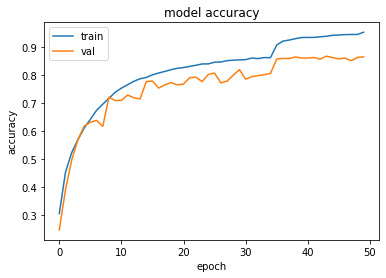

In [4]:
# Set a checkpoint to save weights
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "val_loss", verbose = 1, save_best_only = True, mode = "auto")
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model = createGoogLeNet(.1)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights") 

history = model.fit({"image": train_x}, {"out": train_y}, epochs = 50, validation_split = .2, callbacks = [cp, lr], batch_size = 64)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()


Here we test our model on test set and show how GoogLeNet predicts on sample images in the test set.

Test Accuracy: 85.44%


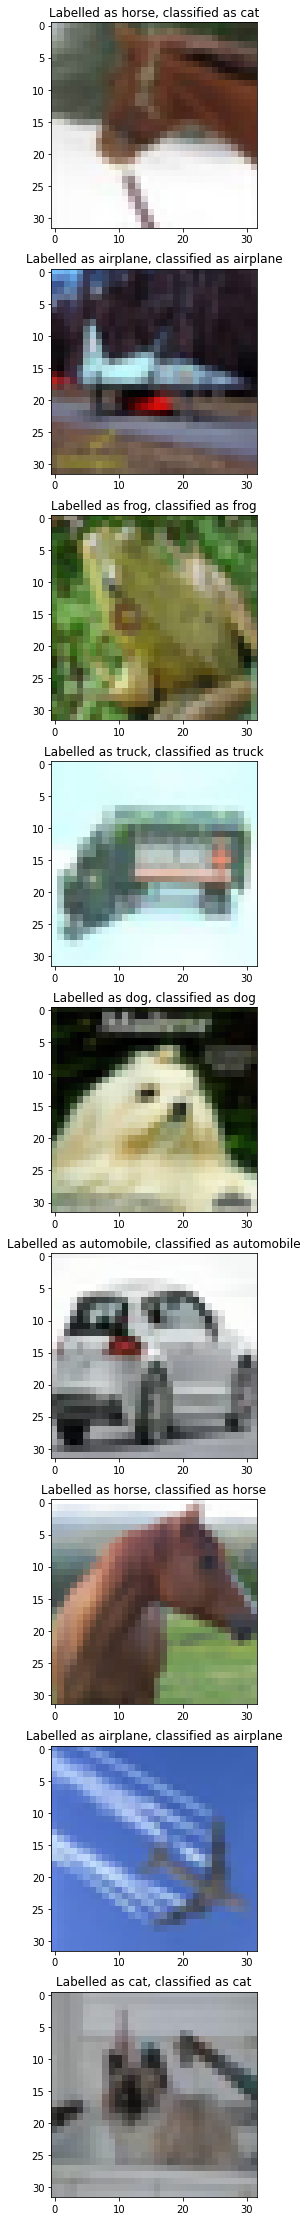

In [5]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

pred = np.argmax(model.predict(test_x), axis = 1)

print("Test Accuracy: {:.2%}".format(np.sum(pred == test_y) / len(test_y)))

sample_data = test_x[: 9]
sample_label = test_y[: 9]

fig = plt.figure(figsize = (10, 40))

for i in range(len(sample_data)):
    ax = fig.add_subplot(911 + i)
    ax.imshow(test_x[i])

    ax.set_title("Labelled as " + labels[int(sample_label[i])] + ", classified as " + labels[int(pred[i])])